# 0. GPU 확인

In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2021-12-01 19:44:28.508495: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8249962219231318089]

# 1. Create Dataset

In [2]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import os
import glob
import random
import cv2

## 1.1. data path

In [3]:
test_data_path = './data/test_and_save_data/original_data'
test_image_paths = glob.glob(os.path.join(test_data_path, '*'))
test_image_paths = sorted(test_image_paths)
test_image_paths

['./data/test_and_save_data/original_data/img_01.JPEG',
 './data/test_and_save_data/original_data/img_02.JPEG',
 './data/test_and_save_data/original_data/img_03.JPEG',
 './data/test_and_save_data/original_data/img_04.JPEG',
 './data/test_and_save_data/original_data/img_05.JPEG',
 './data/test_and_save_data/original_data/img_06.JPEG',
 './data/test_and_save_data/original_data/img_07.JPEG',
 './data/test_and_save_data/original_data/img_08.JPEG',
 './data/test_and_save_data/original_data/img_09.JPEG',
 './data/test_and_save_data/original_data/img_10.JPEG',
 './data/test_and_save_data/original_data/img_11.JPEG',
 './data/test_and_save_data/original_data/img_12.JPEG',
 './data/test_and_save_data/original_data/img_13.JPEG',
 './data/test_and_save_data/original_data/img_14.JPEG']

## 1.2. Custom Dataset Class

In [4]:
class Custom_Image_Dataset(Dataset) :
    
    def __init__(self, image_paths, transforms=None):
        self.image_paths = image_paths
        self.transforms = transforms
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        
        x = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)/255
        y = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255
        
        if self.transforms is not None :
            x = self.transforms(x).float()
            y = self.transforms(y).float()
        
        return x, y

## 1.3. Data Load

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [6]:
test_dataset = Custom_Image_Dataset(test_image_paths, transform)
test_dataloader = DataLoader(test_dataset, batch_size = 4, shuffle = False)

# 2. Load Model

In [7]:
import torch
import torch.nn as nn

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2.1. define model function

In [33]:
class UNET(nn.Module) :
    def __init__(self) :
        super().__init__()
        
        def conv(in_dim, out_dim) :
            model = nn.Sequential(
                nn.Conv2d(in_dim, out_dim, kernel_size=3, padding='same'),
                nn.BatchNorm2d(out_dim),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_dim, out_dim, kernel_size=3, padding='same'),
                nn.BatchNorm2d(out_dim),
                nn.ReLU(inplace=True)
            )
            return model
        
        def max_pool() :
            model = nn.MaxPool2d(2)
            return model
        
        def up_conv(in_dim, out_dim) :
            model = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(in_dim, out_dim, kernel_size=2, padding='same')
            )
            return model
        
        self.input = nn.Sequential()
        self.enc1 = conv(1, 64)
        self.enc2 = nn.Sequential(max_pool(), conv(64, 128))
        self.enc3 = nn.Sequential(max_pool(), conv(128, 256))
        self.enc4 = nn.Sequential(max_pool(), conv(256, 512))
        self.enc5 = nn.Sequential(max_pool(), conv(512, 1024))
        
        self.dec1 = up_conv(1024, 512)
        self.dec2 = nn.Sequential(conv(1024, 512), up_conv(512, 256))
        self.dec3 = nn.Sequential(conv(512, 256), up_conv(256, 128))
        self.dec4 = nn.Sequential(conv(256, 128), up_conv(128, 64))
        self.dec5 = conv(128, 64)
        self.out = nn.Conv2d(64, 3, kernel_size=1, padding = 'same')
        
        
        
    def forward(self, x):
        x = self.input(x)
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x3 = self.enc3(x2)
        x4 = self.enc4(x3)
        x5 = self.enc5(x4)
        
        x = self.dec1(x5)
        x = torch.cat([x, x4], dim = 1)
        x = self.dec2(x)
        x = torch.cat([x, x3], dim = 1)
        x = self.dec3(x)
        x = torch.cat([x, x2], dim = 1)
        x = self.dec4(x)
        x = torch.cat([x, x1], dim = 1)
        x = self.dec5(x)
        x = self.out(x)
        
        
        return x

## 2.2. model compile

In [34]:
trained_model_UNET = UNET().to(device)

## 2.3. load trained state dict path

In [35]:
trained_state_dict_path = './data/model_saved/checkpoint_UNET_RGB.pt'

## 2.3. load saved model 

In [36]:
trained_model_UNET.load_state_dict(torch.load(trained_state_dict_path, map_location=device))

<All keys matched successfully>

# 3. Test

In [37]:
import numpy as np
from tqdm.notebook import tqdm

## 3.1. test function

In [38]:
def test_model(model, test_dataloader) :
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    test_data_list = []
    test_output_list = []
    test_target_list = []
    model.eval()
    
    test_dataloader_tqdm = tqdm(test_dataloader, desc="Test  ")
    for test_data, test_target in test_dataloader_tqdm :
        test_data = test_data.to(device)
        test_target = test_target.to(device)
        
        test_output = model(test_data)
        
        test_data_list.append(test_data.cpu().detach().numpy())
        test_output_list.append(test_output.cpu().detach().numpy())
        test_target_list.append(test_target.cpu().detach().numpy())
        
        del test_data
        del test_target
        del test_output
        torch.cuda.empty_cache()
    
    x = np.concatenate(test_data_list, axis = 0)
    y_predicted = np.concatenate(test_output_list, axis = 0)
    y_real = np.concatenate(test_target_list, axis = 0)
    
    torch.cuda.empty_cache()
    
    return x, y_predicted, y_real

## 3.2. predict

In [15]:
x_test, y_test_predicted, y_test_real = test_model(trained_model_UNET, test_dataloader)

Test  :   0%|          | 0/4 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/conv.py:442: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272482218/work/aten/src/ATen/native/Convolution.cpp:647.)
  return F.conv2d(input, weight, bias, self.stride,


In [16]:
y_test_predicted.shape

(14, 3, 128, 128)

In [17]:
y_test_predicted

array([[[[ 3.05347025e-01,  2.18838140e-01,  2.11837202e-01, ...,
           2.00979024e-01,  1.83245569e-01,  2.07401589e-01],
         [ 2.83966601e-01,  2.28920102e-01,  2.35419020e-01, ...,
           2.14917511e-01,  1.87488601e-01,  1.92315534e-01],
         [ 2.58612484e-01,  2.27228165e-01,  2.41140649e-01, ...,
           2.09559277e-01,  1.96708396e-01,  1.89768195e-01],
         ...,
         [ 1.86200634e-01,  2.98707664e-01,  2.93454170e-01, ...,
           3.44024241e-01,  2.72558153e-01,  2.73997158e-01],
         [ 2.83801466e-01,  2.41625428e-01,  3.14418912e-01, ...,
           3.20322037e-01,  3.35103542e-01,  3.22300464e-01],
         [ 2.59352386e-01,  2.67353892e-01,  2.99673855e-01, ...,
           2.95197427e-01,  3.11425090e-01,  2.81593740e-01]],

        [[ 4.71992195e-01,  4.64480430e-01,  4.74526078e-01, ...,
           4.34549183e-01,  4.20765847e-01,  3.87017041e-01],
         [ 4.75550652e-01,  4.74709630e-01,  4.86812145e-01, ...,
           4.48377997e

## 3.3. 채널 위치 변경

In [18]:
print(y_test_real.shape)
print(y_test_predicted.shape)

(14, 3, 128, 128)
(14, 3, 128, 128)


In [19]:
y_test_real = y_test_real.swapaxes(1, 3).swapaxes(1, 2)
y_test_predicted = y_test_predicted.swapaxes(1, 3).swapaxes(1, 2)
print(y_test_real.shape)
print(y_test_predicted.shape)

(14, 128, 128, 3)
(14, 128, 128, 3)


## 3.4. 최대 최소 맞추기

In [46]:
print(np.min(y_test_predicted))
print(np.max(y_test_predicted))

-0.078885466
1.0989478


In [47]:
y_test_predicted = np.where(y_test_predicted < 0, 0, np.where(y_test_predicted > 1, 1, y_test_predicted))

# 4. Visualizing Test Result

## 4.1. test result visualizing function

In [48]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import minmax_scale
from tensorflow.keras import backend

In [49]:
def show_images(x, y_predicted, y_real, sn = 0):  

    x = x[:, 0, ...]
    
    n = y_predicted.shape[0]
    plt.figure(figsize=(20, 6))
    for i in range(n):

        ax = plt.subplot(3, n, i + 1)
        if x.ndim < 4:
            plt.imshow(x[i+sn], cmap='gray')
        else:
            plt.imshow(x[i+sn])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(y_predicted[i+sn])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n * 2)
        plt.imshow(y_real[i+sn])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

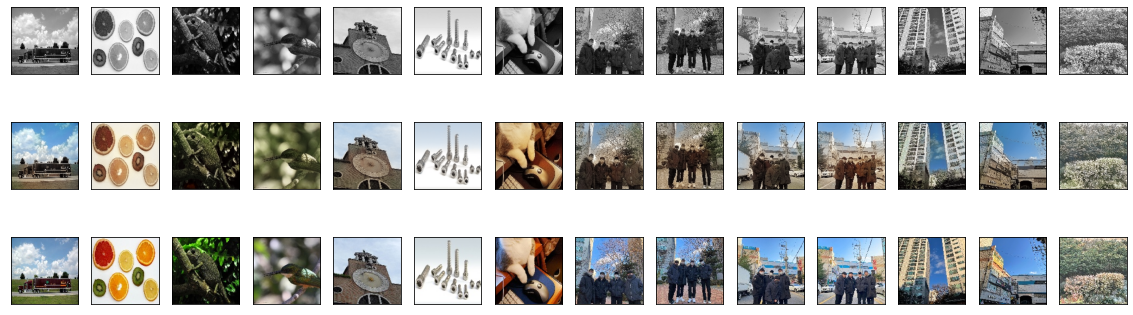

In [50]:
show_images(x_test, y_test_predicted, y_test_real)

# 5. Save Test Result

In [23]:
import cv2

In [54]:
def save_restored_images(y_predicted, image_save_path, image_name) :
    n = y_predicted.shape[0]
    for i in range(n) :
        img_rgb = (y_predicted[i]*255).astype(np.uint8)
        img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
        
        if i+1 < 10 :
            image_name_full = "{}_0{}.JPEG".format(image_name, i+1)
        else :
            image_name_full = "{}_{}.JPEG".format(image_name, i+1)
        
        cv2.imwrite("{}/{}".format(image_save_path, image_name_full), img_bgr)
        
        print(image_name_full, " 저장 완료")

In [55]:
image_save_path = "./data/test_and_save_data/restored_data_unet_rgb"
image_name = "image_unet_rgb"

In [57]:
save_restored_images(y_test_predicted, image_save_path, image_name)

image_unet_rgb_01.JPEG  저장 완료
image_unet_rgb_02.JPEG  저장 완료
image_unet_rgb_03.JPEG  저장 완료
image_unet_rgb_04.JPEG  저장 완료
image_unet_rgb_05.JPEG  저장 완료
image_unet_rgb_06.JPEG  저장 완료
image_unet_rgb_07.JPEG  저장 완료
image_unet_rgb_08.JPEG  저장 완료
image_unet_rgb_09.JPEG  저장 완료
image_unet_rgb_10.JPEG  저장 완료
image_unet_rgb_11.JPEG  저장 완료
image_unet_rgb_12.JPEG  저장 완료
image_unet_rgb_13.JPEG  저장 완료
image_unet_rgb_14.JPEG  저장 완료
